In [2]:
import numpy as np
import time
import random as rnd
import pylab as plb
from scipy.optimize import curve_fit

Time1 = time.time()

Jcrit = np.log(1+np.sqrt(2.))/2
Lx,Ly = 100,100
J = 1.*Jcrit
p_init = 0.5
H=0.

def Energy(sigma,j=J):
    """Returns the energy of the configuration with optionary argumant j, the dafault is Jcritical"""
    return -j*(np.sum(sigma[:,1:]*sigma[:,:-1]) + np.sum(sigma[1:,]*sigma[:-1,]) +
               np.sum(sigma[-1:,]*sigma[0:1,]) + np.sum(sigma[:,0]*sigma[:,-1]))


sigma = np.random.rand(Lx,Ly)
sigma[sigma < p_init ] = 1
sigma[sigma != 1 ] = -1
sigma = sigma.astype('i4')
print(sigma)
print(Energy(sigma))

Time2 = time.time()
print('E.T:',Time2-Time1)

[[-1  1  1 ... -1 -1  1]
 [ 1  1  1 ...  1  1 -1]
 [-1  1 -1 ...  1 -1  1]
 ...
 [ 1  1  1 ...  1 -1 -1]
 [-1  1 -1 ...  1  1  1]
 [ 1  1 -1 ...  1 -1 -1]]
54.64516239521166
E.T: 0.0198671817779541


In [4]:
Time1 = time.time()
print("_______________________")


def my_mcflip(sigma,j):
    """mcflip due my idea ... not used for sampeling"""
    for u in [0,2,1,3]:
        E0 = Energy(sigma,j)
        rand_matrix =  generate_random_matrix(sigma.shape[0],sigma.shape[1],address = u)
        sigma = sigma *rand_matrix
        dE = Energy(sigma) - E0
        if dE <0 or rnd.random() <  np.exp(-dE)/(np.exp(-dE) + np.exp(dE)) :
            pass
        else:
            sigma = sigma *rand_matrix
    return sigma


def magnetization(sigma):
    return abs(1/(sigma.shape[0]*sigma.shape[1])*np.sum(sigma))

Time2 = time.time()
print('E.T:',Time2-Time1)

_______________________
E.T: 0.002980947494506836


In [5]:
def variance(data):
    """Returns the std(standard deviation) of data"""
    data = np.array(data)
    return(np.mean(data**2) - np.mean(data)**2)

def AuoCorrelation(data,j):
    """Finds the AutoCorrelation between samples (data) with distance j"""
    if j == 0:
        return 1.0
    data = np.array(data)
    A = 0
    B = 0
    for i in range(len(data)):
        if i+j < len(data):
            A += data[i]*data[i+j]
            B += data[i+j]

    A/= (len(data)-j)
    B/= (len(data)-j)
    return (A - np.mean(data[:-j])*B)/variance(data)


In [6]:
def energy_matrix(sigma,j=J):
    """returns the matrix energy, A matrix which entities are energy with respect to neighbours"""
    Lx , Ly = sigma.shape
    
    U = np.vstack((sigma[1::],sigma[:1:]))
    D = np.vstack((sigma[-1:-2:-1],sigma[:-1:]))
    L = np.hstack((sigma[:,-1].reshape(Ly,1),sigma[:,:-1]))
    R = np.hstack((sigma[:,1:],sigma[:,0].reshape(Ly,1)))
    
    mEnergy = -j*sigma * (U +  D + L + R)
    return mEnergy

def generate_random_matrix(Lx,Ly,a,b):
    """Generates a random matrix which sublattice random 1,-1 entities"""
    mu = np.ones((Lx,Ly))
    if 0<=a<2 and 0<=b<2 :
        shape = mu[a::2,b::2].shape
        mu[a::2,b::2] = np.random.randint(2, size=shape)
    else:
        return np.ones((Lx,Ly))
    mu[mu == 0] = -1
    return mu

def my_mcflip_sublat(sigma,a,b, J):
    """fliping a sublattice due to my idea, inspired by ICTO code ... It uses metropolis for fliping"""
    Lx, Ly = sigma.shape
    E0 = energy_matrix(sigma,J)[a::2,b::2]
    rand_matrix = generate_random_matrix(Lx,Ly,a,b)
    Eprim = energy_matrix(sigma*rand_matrix,J)[a::2,b::2]
    
    m = np.exp(-Eprim+E0)
    p = (m+1)/2
    
    sigma[a::2,b::2] = 2*(np.random.rand(Lx//2,Ly//2) < p) - 1

    return sigma


def mcflip(sigma, J):
    sigma = mcflip_sublat(sigma,0,0, J)
    sigma =mcflip_sublat(sigma,1,0, J)
    sigma =mcflip_sublat(sigma,0,1, J)
    sigma =mcflip_sublat(sigma,1,1, J)
    return sigma
print(sigma)
mcflip(sigma,J)

[[ 1  1  1 ... -1 -1 -1]
 [-1 -1 -1 ...  1  1  1]
 [-1  1  1 ... -1  1 -1]
 ...
 [ 1 -1  1 ...  1 -1 -1]
 [-1  1  1 ... -1  1  1]
 [-1  1 -1 ... -1  1 -1]]


array([[ 1, -1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1, -1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1]])

In [7]:
def mcflip_sublat(sigma,a,b, J):
    """Update on sublattices defined by and randomly flip with probability
    set by the relative Gibbs weight."""
    Lx, Ly = sigma.shape
    
    localH = J * (
            sigma[2+a:   :2, 1+b: -1:2] + # to the right
            sigma[  a: -2:2, 1+b: -1:2] + # to the left
            sigma[1+a: -1:2, 2+b:   :2] + # up
            sigma[1+a: -1:2,   b: -2:2]   # down
            )
    
    m = np.tanh(localH)
    p = (m+1)/2
    
    sigma[1+a:-1:2, 1+b:-1:2] = 2*(np.random.rand(Lx//2-1,Ly//2-1) < p) - 1
                
    return sigma

def mcflip(sigma, J):
    sigma = mcflip_sublat(sigma,0,0, J)
    sigma = mcflip_sublat(sigma,1,0, J)
    sigma = mcflip_sublat(sigma,0,1, J)
    sigma = mcflip_sublat(sigma,1,1, J)
    return sigma

In [1811]:
"""Animationing"""
plb.rcParams['figure.figsize'] = 12,5
for s in range(10):
        mcflip(sigma,1.7*J)
        fig = plb.figure()
        
        plb.subplot(1,2,1)
        
        fig = plb.imshow(sigma,origin = 0)
        plb.title('J = {}*Jcrit'.format(1.7),fontsize=16)
        
        plb.subplot(1,2,2)
        #This datas has been collected already
        Xu = np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7])*J
        Yu = [0.0138,0.01628,0.021648,0.0312,.05477,0.0889,0.15863,0.302,0.4782,0.58761,0.78673,0.8972,0.90919]
        plb.plot([Jcrit]*20,np.linspace(0,1,20),linestyle="--",label="J critical",color="orange")
        plb.scatter(Xu,Yu,label="data points",color="black")
        plb.plot(Xu,Yu,label="Fitting curves",color="blue")
        
        plb.title('|<m>| versus J for 100x100 Lattice',fontsize=15)
        plb.xlabel('J which is j/T',fontsize=15)
        plb.ylabel('|<m>|',fontsize=15)
        plb.legend()
        
        plb.savefig('Desktop/PICSS/17,{}.png'.format(s))
plb.imshow(sigma,origin=(0,0))
plb.title('{}*Jcrit'.format('5.'),fontsize=16)

Text(0.5, 1, '5.*Jcrit')

Error in callback <function flush_figures at 0x0000019267412488> (for post_execute):


KeyboardInterrupt: 

In [959]:

Time1 = time.time()
#Sorry for choosing arrays names so badly
Xs ,Ys =[],[]
#Temp arrays for collecting data and manipulation
Dat , Dat2  = [] ,[]
#Collecting data from where to where
Arrss = list(np.linspace(0.*Jcrit,0.9*Jcrit,7)) + list(np.linspace(0.91*Jcrit,1.1*Jcrit,10)) + list(np.linspace(1.15*Jcrit,2*Jcrit,5))

#for mu in [1.0*Jcrit]:
for mu in Arrss:

    for __ in range(5000):
        mcflip(sigma,mu)
        
    Dat = []
    
    for j in range(8000):
        
        sigma = mcflip(sigma,mu)

        if j%100 == 0:
            #To get the parameters by specified step ... here magnetization
            #for Cv or susceptibility we collect data and just use variance function defined above
            Dat.append(magnetization(sigma))
    Dat2.append(Dat)

Time2 = time.time()
print('E.T:',Time2-Time1)

E.T: 13.831573247909546


2.522465874622437

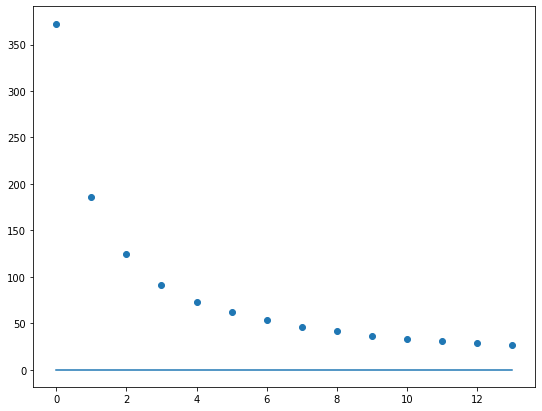

In [268]:
#Here I got the values of correlation of data(magnetization)
plb.rcParams['figure.figsize'] = 9,7
Xlm = range(14)
Ylm = aaaaa
plb.scatter(Xlm,Ylm)
plb.plot(Xlm,[np.exp(-1)]*len(Xlm))

p =np.polyfit(Xlm[0:5],np.log(Ylm)[0:5],1)
#This is the correlation (Time)
-1/p[0]


In [399]:
#Evolve The lattice through the time
Etttt1 = time.time()
for _ in range(5000):
        mcflip(sigma,0.6*Jcrit)
time.time() - Etttt1

7.443448066711426

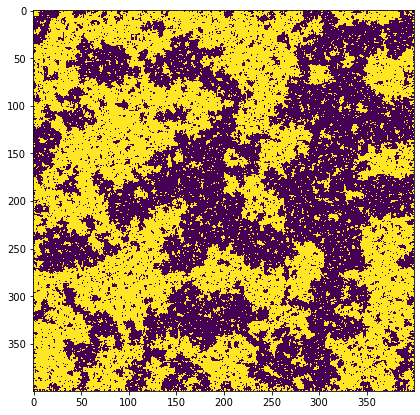

In [294]:
#The Representation
plb.imshow(sigma)

Text(0, 0.5, '|<m>|')

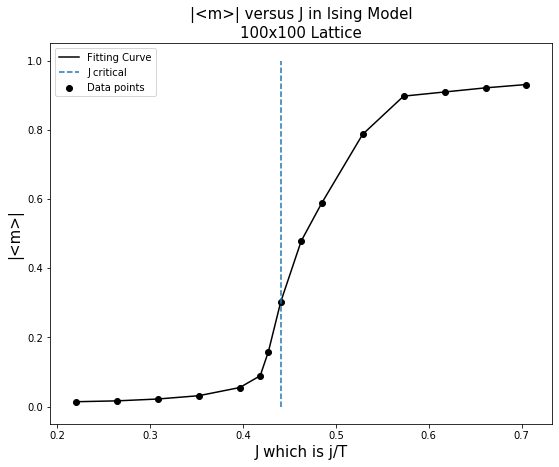

In [73]:
# Data for 100x100 and magnetization
Xu = np.array([0.5,0.6,0.7,0.8,0.9,0.95,0.97,1,1.05,1.1,1.2,1.3,1.4,1.5,1.6])*J
Yu = [0.0138,0.01628,0.021648,0.0312,.05477,0.0889,0.15863,0.302,0.4782,0.58761,0.78673,
     0.8972,0.90919,0.92117,0.9308]

plb.plot(Xu,Yu,label="Fitting Curve",color='black')
plb.scatter(Xu,Yu,c='k',label="Data points")
plb.plot([Jcrit]*20,np.linspace(0,1,20),linestyle="--",label="J critical")

plb.legend()
plb.title('|<m>| versus J in Ising Model\n100x100 Lattice',fontsize=15)
plb.xlabel('J which is j/T',fontsize=15)
plb.ylabel('|<m>|',fontsize=15)

In [74]:
def AutoCorrelation(data,j):
    """Finds the Autocorrelation between samples (data) with distance j"""
    if not j:
        return 1
    data = np.array(data)
    A = 0
    B = 0
    for i in range(len(data)):
        if i+j < len(data):
            A += data[i]*data[i+j]
            B += data[i+j]

    A/= (len(data)-j)
    B/= (len(data)-j)
    return (A - np.mean(data[:-j])*B)/variance(data)


In [ ]:
#Here we collect the data which we produced in top
"""For exmaple if on top you collected magnetization data Here you by using variance you will find susceptibility
    or errorbar of magnetization and by np.mean you will find magnetization"""
XxX = []
for k in range(len(Dat2)):
    #XxX.append(variance(Dat2[k]))
    XxX.append(np.mean(Dat2[k]))
print(Arrss)
print(XxX)

(array([0.43047624]), array([[0.02053458]]))


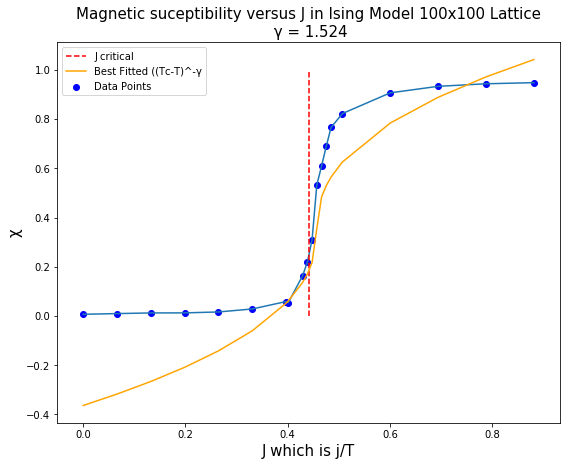

In [899]:
#Here for example I copied the datas above and fit a curve to it and add errorbars and change titles
#data are typicall
#feel free to play with it :)

aa = [0.0, 0.06610301902646572, 0.13220603805293143, 0.19830905707939717, 0.26441207610586287,
      0.3305150951323286, 0.39661811415879433, 0.40102498209389204,
      0.42893514568284424, 0.4382385335458283, 0.4475419214088124, 0.45684530927179645, 0.4661486971347805,
      0.4754520849977646, 0.48475547286074866, 0.5067898125362371, 0.6004357561570636, 0.69408169977789,
      0.7877276433987165, 0.8813735870195429] 

cc = [0.006888, 0.0096256, 0.0122912, 0.0125248, 0.016291200000000002, 0.028395200000000002, 0.0584880,
      0.0543328, 0.16280640000000005, 0.21770400000000004, 0.3089968, 0.5321360000000002,
      0.6092752000000001, 0.6904, 0.7658688000000001, 0.8221328, 0.9064336000000002, 0.9328880000000002,
      0.9432608, 0.9477519999999999]

cc = np.array(cc)
#discomment below to plot with errorbars , U should find the yerr before plotting
#plb.errorbar(aa,cc,yerr,ecolor="black",capsize=5, elinewidth=1.,markeredgewidth=1.,color='black')
plb.plot(aa,cc)
plb.plot([Jcrit]*20,np.linspace(0,1,20),linestyle="--",label="J critical",c='red')
plb.scatter(aa,cc,label="Data Points",color='blue')

plb.title('Magnetic suceptibility versus J in Ising Model 100x100 Lattice\n \u03b3 = 1.524',fontsize=15)
plb.xlabel('J which is j/T',fontsize=15)
plb.ylabel('\u03c7',fontsize=15)
#put the T critical in your lattice in defining func
func = lambda x,a: abs( 0.45684 - x )**(a)


print(curve_fit(func, aa, cc))
TT = []

for ii in aa:
    TT.append(func(ii,0.43047))

TT = np.array(TT)
#Some times the plot needs some shift or renormalizations
plb.plot(aa,(TT+.35),label="Best Fitted ((Tc-T)^-\u03b3",c='orange')
plb.legend()


[0.0, 0.06610301902646572, 0.13220603805293143, 0.19830905707939717, 0.26441207610586287, 0.3305150951323286, 0.39661811415879433, 0.40102498209389204, 0.4103283699568761, 0.4196317578198602, 0.42893514568284424, 0.4382385335458283, 0.4475419214088124, 0.45684530927179645, 0.4661486971347805, 0.4754520849977646, 0.48475547286074866, 0.5067898125362371, 0.6004357561570636, 0.69408169977789, 0.7877276433987165, 0.8813735870195429] [0.0, 89.58769084498635, 362.33732907279045, 1070.0664053272922, 1891.2332750698552, 3885.2428032364696, 7345.120703302324, 6832.912468716502, 10695.592310197651, 11113.540187682956, 12093.162709452212, 15374.983583223075, 15752.271178893745, 14607.273757651448, 13323.601320296526, 11395.831804156303, 9004.581343658268, 7002.990357026458, 4180.276128575206, 1797.578729212284, 1147.17209482193, 542.5791424512863]


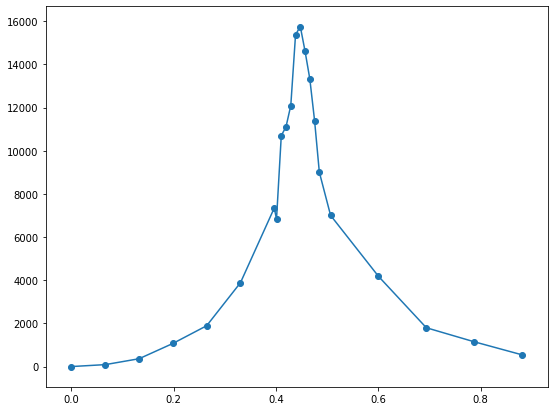

In [900]:
#plot the datas Just for seeing
plb.plot(Arrss,XxX)
plb.scatter(Arrss,XxX)

Text(0, 0.5, 'C(τ)')

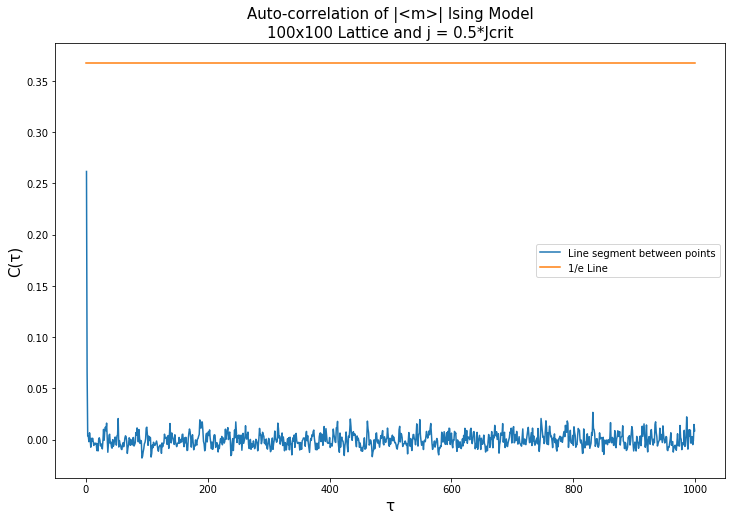

In [396]:
#Plots for finding sampling AutoCorrelation
Temp = []
crrs = []
for j in range(1000):
    #sigma = mcflip(sigma,0.4*Jcrit)
    Temp.append(AutoCorrelation(man,j))
plb.plot(list(range(len(Temp))),Temp,label="Line segment between points")
plb.plot(list(range(len(Temp))),[np.exp(-1)]*1000,label="1/e Line")
plb.legend()
plb.title('Auto-correlation of |<m>| Ising Model\n100x100 Lattice and j = 0.5*Jcrit',fontsize=15)
plb.xlabel('\u03c4',fontsize=15)
plb.ylabel('C(\u03c4)',fontsize=15)

In [694]:
#Spin Spin correlation, The hardest and longest part .... ):
#Just use this code after Equilibirium state
# first we run the first for loop once and uncomment below to make the array Ask
# then in first run in the end of code uncommment append
# for next tries comment below and also comment append in the end of code

"""ASk = []

for _ in range(5000):
    mcflip(sigma,0.6*Jcrit)"""

def Correlation_func(A,B):
    """The correlation of two sets ... A and B"""
    A = np.array(A)
    B = np.array(B)
    return (np.mean(A*B) - np.mean(A)*np.mean(B))/(np.sqrt(variance(A))*np.sqrt(variance(B)))

for _____ in range(100):
    
    Where = 90    #equivalent to l
    #random houses
    r_x = rnd.randint(0,Lx-1)
    r_y = rnd.randint(0,Ly-1)
    #spin arrays
    S1 , S2 = [ [] for x in range(Lx-1)] , [ [] for x in range(Lx-1)]
    #collecting datas
    for l in range(1,Where):
        for i in range(80):
            S1[l].append(sigma[(r_x+i)%Lx,r_y])
            S2[l].append(sigma[(r_x+i)%Lx,(r_y+l)%Ly])
        #you should change the J here manually
        mcflip(sigma,1.0*Jcrit)
    
    #can u understand why i do that?
    S1.remove([])
    S2.remove([])
    S1 = np.array(S1)
    S2 = np.array(S2)


    Spinor = []
    
    for que in range(Where-1):
        Spinor.append( Correlation_func(S1[que],S2[que]))

    for i , k in enumerate(Spinor):
        #ASk.append(k)
        ASk[i] += k

[2.50752121 1.75380988 1.4180671  1.1781271  1.08727843 0.88731511
 0.83921377 0.77384464]


6.267744033375508

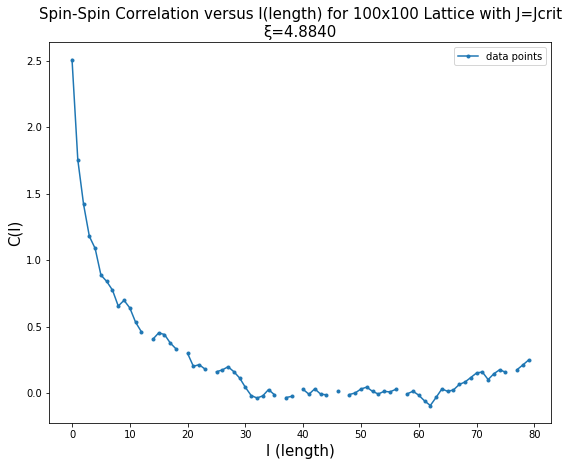

In [698]:
#A typicall plot for finding the Xi or spin spin correlation length
plb.plot(range(len(ASk[:80])),np.array(ASk[:80])/80,marker=".",label="data points")
#plb.plot(list(range(len(ASk))),[np.exp(-1)]*89,label="1/e Line")
plb.legend()
plb.title('Spin-Spin Correlation versus l(length) for 100x100 Lattice with J=Jcrit\n\u03be=4.8840',fontsize=15)
plb.xlabel('l (length)',fontsize=15)
plb.ylabel('C(l)',fontsize=15)

print((np.array(ASk[0:8])/80))
uuuuu = np.polyfit(range(8),np.log(np.array(ASk[0:8])/80),1)
-1/uuuuu[0]
#print(len(ASk))